('\n*==* script /opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py executing \n', '     processing file Quast_Hysterese.csv')
  --> 3 columns recieved
      units ['(ms)', '(V)', '(V)'] ('  sample length ', 7817, '\n')
('** resampling by factor ', 52)
** spline interpolation


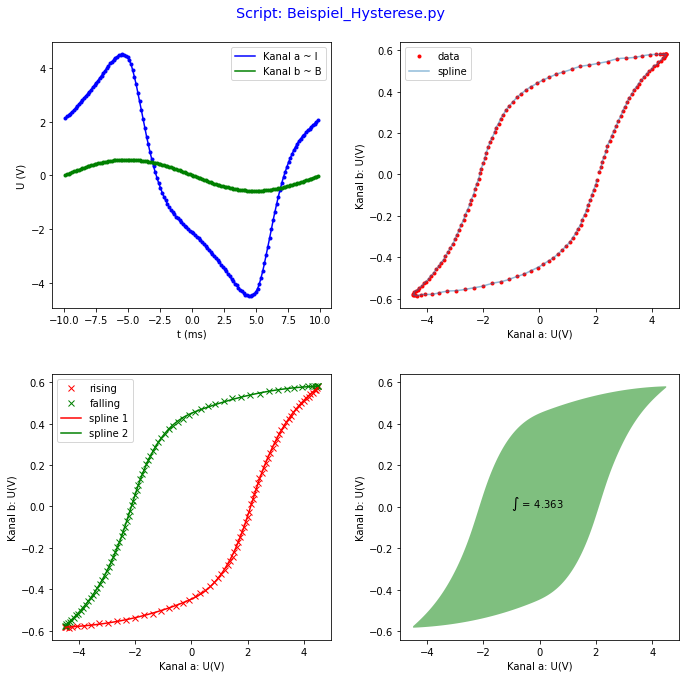

In [3]:
# -*- coding: utf-8 -*-
"""Beispiel_Hysterese.py 
   Auswertung der Daten aus einer mit PicoScope erstellten Datei
   im txt-Format am Beispiel des Hystereseversuchs
   * Einlesen der Daten aus PicoScope-Datei vom Typ .txt oder .csv
   * Darstellung  Kanal_a vs. Kanal_b
   * Auftrennung in zwei Zweige für steigenden bzw. abnehmenden Strom
   * Interpolation durch kubische Splines
   * Integration der Spline-Funktionen
.. moduleauthor:: Guenter Quast <g.quast@kit.edu>
"""

# -----example Code illustrating usage --------------------
if __name__ == "__main__":
  import numpy as np, matplotlib.pyplot as plt
  from PhyPraKit import readPicoScope, resample
  from scipy import signal
  from scipy import interpolate
  import sys

  # check for / read command line arguments
  if len(sys.argv)==2:
    fname=sys.argv[1]
  else:
    fname='Quast_Hysterese.csv'
  print(('\n*==* script ' + sys.argv[0]+ ' executing \n',\
      '     processing file ' + fname)) 

  # read data from PicoScope
  units, data = readPicoScope(fname)
  ic = len(data)
  print("  --> %i columns recieved"%ic)
  print("      units", units, end=' ') 
  t = data[0]
  l=len(t)
  print(("  sample length ", l, '\n'))

  # this depends on cabling of the PicoScope !
  vI = data[2] # proportional to Current
  vB = data[1] # proportional to B-Field

  # if length is too large, resample by appropriate factor
  if l > 400:
    nr = int(l/150)
    print(('** resampling by factor ', nr))
    vI, t = resample(vI, t, n=nr)  
    vB = resample(vB, n=nr)  
 

  print('** spline interpolation') 
  cs_I=interpolate.UnivariateSpline(t, vI, s=0)
  cs_B=interpolate.UnivariateSpline(t, vB, s=0)
  tplt=np.linspace(t[0],t[-1], 150)

  # take derivative of channel a 
  #  -- this is used to determine the branch of the hysteresis curve
  cs_Ideriv=cs_I.derivative()
  # for increasing current
  Ip=[]
  Bp=[]
  # for decreasing current
  Im=[]
  Bm=[]
#  tlist = np.linspace(t[0], t[-1], 200) #
  for i, ti in enumerate(t): 
    if(cs_Ideriv(ti) > 0.):
      Ip.append(vI[i])
      Bp.append(vB[i]) 
    else:
      Im.append(vI[i])
      Bm.append(vB[i])
  # convert to (simultaneously) sorted arrays ...
  idxp=np.argsort(Ip)
  Ip=np.array(Ip)[idxp]
  Bp=np.array(Bp)[idxp]
  idxm=np.argsort(Im)
  Im=np.array(Im)[idxm]
  Bm=np.array(Bm)[idxm]
  # ... and provide smooth spline approximation 
  #   !!! adjusting s is magic here, should correspond to the "precision"  
  prec=(max(Ip)-min(Ip))*10e-5
  cs_Bp=interpolate.UnivariateSpline(Ip, Bp, s=prec)
  cs_Bm=interpolate.UnivariateSpline(Im, Bm, s=prec)
  # calculate integral between curves
  Imin = max(np.min(Ip), np.min(Im))
  Imax = min(np.max(Ip), np.max(Im))
  integral= cs_Bm.integral(Imin, Imax) - cs_Bp.integral(Imin, Imax)

# plot results
  fig=plt.figure(1, figsize=(10.,10.))
  fig.suptitle('Script: Beispiel_Hysterese.py', size='x-large', color='b')
  fig.subplots_adjust(left=0.1, bottom=0.1, right=0.97, top=0.93,
                    wspace=.25, hspace=.25)

# plot raw data ...
  ax1=fig.add_subplot(2, 2, 1)
#  ax1.set_ylim(np.min(a)*1.05, np.max(a)*1.7)
  ax1.plot(t, vI, 'b.')
  ax1.plot(tplt, cs_I(tplt), 'b-', label='Kanal a ~ I')
  ax1.plot(t, vB, 'g.')
  ax1.plot(tplt, cs_B(tplt), 'g-', label='Kanal b ~ B')
  ax1.set_xlabel('t ' + units[0])
  ax1.set_ylabel('U ' + units[1])
  ax1.legend(numpoints=1, loc='best')

# ... and interpolated data a vs. b
  ax2=fig.add_subplot(2, 2, 2)
  tplt = np.linspace(t[0], t[-1], 200)
  ax2.plot(vI, vB, 'r.', label='data')
  ax2.plot(cs_I(tplt), cs_B(tplt), '-', alpha=0.5, label='spline')
  ax2.set_xlabel('Kanal a: U'+units[1])
  ax2.set_ylabel('Kanal b: U'+units[2])
  ax2.legend(numpoints=1, loc='best')
# plot separate branches 
  ax3=fig.add_subplot(2, 2, 3)
  ax3.plot(Ip, Bp, 'rx', label='rising')
  ax3.plot(Im, Bm, 'gx', label='falling')
  Iplt = np.linspace(Imin, Imax, 200)
  ax3.plot(Iplt, cs_Bp(Iplt), 'r-', label='spline 1')
  ax3.plot(Iplt, cs_Bm(Iplt), 'g-', label='spline 2')
  ax3.legend(numpoints=1, loc='best')
  ax3.set_xlabel('Kanal a: U'+units[1])
  ax3.set_ylabel('Kanal b: U'+units[2])
# plot interpolated functions and integral
  ax4=fig.add_subplot(2, 2, 4)
 # form a singele contour to plot
  ax4.fill( np.concatenate( (Iplt, np.flipud(Iplt)) ), 
            np.concatenate( (cs_Bp(Iplt), np.flipud(cs_Bm(Iplt)) )),
           'g', alpha=0.5)
  #ax4.fill(Iplt, cs_bB(Iplt), 'g', alpha=0.5)
  #ax4.fill(Iplt, cs_Bm(Iplt), 'g', alpha=0.5)
  ax4.text(-1., 0., '$\int\,=\,$%.4g'%integral)
  ax4.set_xlabel('Kanal a: U'+units[1])
  ax4.set_ylabel('Kanal b: U'+units[2])

  plt.show()